Dans ce notebook, on vous propose de tester la fonction d'optimisation $\verb+optimize_merton+$ de la classe $\verb+Option+$. La méthode est la suivante, on split la data scrapée en deux dataframes $\verb+train+$ et $\verb+test+$ dont la proportion est assurée par le paramètre $\verb+test_size+$

Ensuite on va optimiser les paramètres de Merton sur le DataFrame $\verb+train+$, puis on calcule la précision du modèle sous ces paramètres sur le DataFrame $\verb+test+$ avec la métrique RMSE.

Le plus simple est la définition d'une Pipeline de test $\verb+testing_pipeline+$ qui effectue toutes ces étapes pour une proportion donnée, on peut ensuite faire varier ce coefficient proportionnel et regarder comment varient les précisions

In [3]:
import deribit_data as dm
from option import Option
import numpy as np
from utils import *
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import time
import pandas as pd
from threading import Thread

In [ ]:
data = dm.Scraper(currency='BTC')

In [ ]:
raw_df = data.collect_data(max_workers = 15, save_csv = False)

In [ ]:
def testing_pipeline(test_size = .2):
    
    train, test = train_test_split(raw_df, test_size = test_size)
    
    option_train = Option(train, 'B')
    option_test  = Option(test , 'B')
    
    part1(option_test)
    part1(option_train)
    
    option_train.init_merton(reset=True)
    option_test.init_merton(reset=True)
    
    option_train.append_loc_vol_to_df()
    option_test.append_loc_vol_to_df()
    
    option_train.append_BS_price()
    option_test.append_BS_price()
    
    option_train.df.drop(option_train.df[option_train.df.BS_PRICE >= .5].index, inplace = True)
    option_test.df.drop(option_test.df[option_test.df.BS_PRICE >= .5].index, inplace = True)
    
    option_train.df.dropna(inplace=True)
    option_test.df.dropna(inplace=True)
    
    optimized_X = option_train.optimize_merton(tol = 1e-6, max_iter = 400)
    option_test.init_merton(optimized_X[0], optimized_X[2], optimized_X[1])
    
    option_train.append_Merton_price()
    option_test.append_Merton_price()
    
    
    rms_train = mean_squared_error(option_train.df['MERTON_PRICE'], option_train.df['mid'], squared=False)
    rms_test = mean_squared_error(option_test.df['MERTON_PRICE'], option_test.df['mid'], squared=False)


    print('RMSE Train = {}%'.format(round(rms_train*100,3)))
    print('RMSE Test  = {}%'.format(round(rms_test*100,3)))
    
    return rms_train, rms_test

In [ ]:
test_sizes = np.linspace(.1,.9,9)
print(test_sizes)

On peut maintenant regarder comment varient les précisions pour toutes ces proportions : 
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
start = time.process_time()
rms_train, rms_test = np.vectorize(testing_pipeline)(test_sizes)
print("Calculé en {}s".format(round(time.process_time() - start, 3)))



single thread: Calculé en 1154.593s

In [ ]:
test_df = pd.DataFrame([test_sizes, rms_train, rms_test],index=['test_sizes', 'rms_train', 'rms_test']).T
#test_df.to_csv("test_optimisation.csv")


In [4]:
test_df = pd.read_csv('test_optimisation.csv')[['test_sizes','rms_train','rms_test']]

In [5]:
test_df.head(100)

,test_sizes,rms_train,rms_test
0,0.1,0.007626,0.002013
1,0.2,0.028188,0.031036
2,0.3,0.007729,0.017400
3,0.4,0.075675,0.062980
4,0.5,0.014000,0.007629
5,0.6,0.008158,0.013672
6,0.7,0.036458,0.025079
7,0.8,0.014861,0.030348
8,0.9,0.026314,0.009216


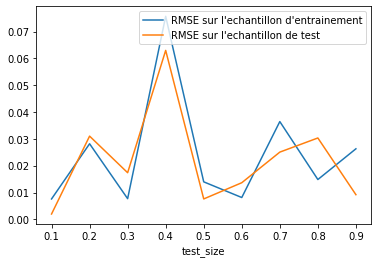

In [8]:
plt.plot(test_df['test_sizes'], test_df['rms_train'],label='RMSE sur l\'echantillon d\'entrainement')
plt.plot(test_df['test_sizes'], test_df['rms_test'],label='RMSE sur l\'echantillon de test')
plt.xlabel('test_size')
plt.legend()
plt.show()

On remarque que la précision ne diminume pas significativement lorsque l'on optimise les paramètres de Merton seulement sur un petit echantillont de toute la donnée du marché. On pourra donc procéder de cette façon pour estimer les paramètres et ainsi gagner grandement en temps de calcul.